# Doodle recognizer

Training of a neuronal network for classifying basic drawings using convolutional neuronal networks

In this notebook two networks are trained:

* A basic neuronal network with two classes
* A convolutional network involving 10 classes

Then, a comparison between the two nets is presented.

Training data was taken from a dataset with about 50 million of drawings divided in 345 different categories made by people around the world who played **Quickdraw!**, a game where they have to draw a word with limited time.

The metric chosen for this problem is the accuracy because we are working with multiple clases which have a balanced amount of observations.

# Imports

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 40.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from torchmetrics import F1Score, ConfusionMatrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data 
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from random import randint

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

# Download the data to be used


In [ ]:
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cookie.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/clock.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/boomerang.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/snail.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/parachute.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tree.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fish.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/diamond.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/helicopter.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/t-shirt.npy

--2023-05-22 21:16:24--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cookie.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102980832 (98M) [application/octet-stream]
Saving to: ‘cookie.npy’

cookie.npy          100%[===================>]  98.21M  19.9MB/s    in 6.1s    

2023-05-22 21:16:30 (16.2 MB/s) - ‘cookie.npy’ saved [102980832/102980832]

--2023-05-22 21:16:30--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/clock.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94500304 (90M) [application/octet-stream]
Sa

Due to RAM utilization, all the notebook can't be run at once, if you want the preeliminary results then you must only run the first section, if you want the final model then you must run only the last section

# Conventional neuronal network

This model is going to serve as a reference point for further work

In [ ]:
cookies = np.load("cookie.npy")
boomerangs = np.load("boomerang.npy")

categories = [cookies, boomerangs]
str_categories = ["cookies", "boomerangs"]

Combining all categories in one

In [ ]:
X = np.zeros((1, 784))
y = np.zeros((1, 1))

for i, cat in enumerate(categories):
  X = np.vstack((X, cat))
  y = np.vstack((y, i*np.ones((cat.shape[0], 1))))

X = X[1:, :]
y = y[1:, :]

Function to visualize one of the images in the dataset

In [ ]:
def show_image(data:np.ndarray, index:int) -> None:
  img = data[index, :]
  img = img.reshape(28, 28)
  plt.matshow(img, cmap="gray")

Dividing the dataset in train, validation and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=.9, random_state=41)               # 90% of data will be for training

x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42)     # 10% * 50% = de 5% of data
                                                        # will be used for validation
                                                        # the remaining 5% will be for testing


## Pytorch model

This neuronal network is going to serve as a start point to compare our final result

In [ ]:
# Create ANN Model
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(X.shape[1], 150) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(150, 150)
        # Non-linearity 2
        self.relu2 = nn.ReLU()
        
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(150, 150)
        # Non-linearity 3
        self.relu3 = nn.ReLU()
        
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(150, len(categories))
    

    def forward(self, x):
        # Linear function 1
        x = self.fc1(x)
        # Non-linearity 1
        x = self.relu1(x)
        
        # Linear function 2
        x = self.fc2(x)
        # Non-linearity 2
        x = self.relu2(x)
        
        # Linear function 2
        x = self.fc3(x)
        # Non-linearity 2
        x = self.relu3(x)
        
        # Linear function 4 (readout)
        x = self.fc4(x)
        return x


Create the model, define its loss function and optimizer

In [ ]:
def createModel(alpha):
  ANN = Net()
  # Loss Function
  lossfun = nn.CrossEntropyLoss()
  # Optimizer
  optimizer = torch.optim.SGD(ANN.parameters(),lr=alpha)
  return ANN,lossfun,optimizer

Function to create and train the model

In [ ]:
def create_and_train(alpha=0.01, epochs=500, verbose=True, save_best=True):

  valid_loss_min = np.inf  #Vamos a encontrar el menor valor de error de validación. Por eso la inicializmaos como 'infinito'.

  # Inicializamos dos listas de accuracies vacías y una lista de pérdidas.
  trainAcc = []
  testAcc  = []
  losses   = []

  # Creamos una instancia de una red neuronal, una función de error y un criterio para minimizar.
  ANN, lossfun, optimizer = createModel(alpha)

  # Iteramos "epochs" veces
  for epoch in range(epochs):


    # ======================================================================== #
    #                                ENTRENAMIENTO                             #
    # ======================================================================== #


    # Activamos el modo entrenamiento.
    ANN.train()

    # Iteramos sobre cada bache de datos en el dataset, inicializamos listas para guardar las pérdidas y precisiones para cada bache.
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # Hacemos forward propagation y calculamos el error o pérdida.
      yHat = ANN(X)
      loss = lossfun(yHat,y.squeeze())

      # Hacemos backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculamos la precisión de entrenamiento para este bache solamente.
      _, predicted = torch.max(yHat.data, 1)                                                 # Si output > 0.5, la clase es positiva (1). En otro caso, la clase es negativa (0)
      batchAcc.append(100*(predicted == y.squeeze()).sum().item()/y.shape[0])
      batchLoss.append(loss.item())

    # Terminamos de iterar sobre los baches...

    # Ahora que iteramos sobre todos los baches, obtenemos su precisión y error medio.
    train_acc = np.mean(batchAcc)
    train_loss = np.mean(batchLoss)

    # Guardamos esta información.
    trainAcc.append(train_acc)
    losses.append(loss.detach().numpy())


    # ======================================================================== #
    #                                 VALIDACIÓN                               #
    # ======================================================================== #


    # Extraemos X, y del dataloader.
    X,y = next(iter(cv_loader))

    # Activamos el modo de testeo.
    ANN.eval()
    with torch.no_grad():
      output = ANN(X)
    
    # Calculamos la precisión para este bache.
    _, predicted = torch.max(output.data, 1)
    test_acc = 100*(predicted == y.squeeze()).sum().item()/y.shape[0]
    testAcc.append(test_acc)

    # Calculamos el puntaje F1 (Nos dice qué tan bien se desempeña el modelo teniendo en relación a las
    # predicciones de falsos positivos y falsos negativos en las qwe incurre).
    f1 = F1Score(task="multiclass", num_classes=3)
    _, predicted = torch.max(output.data, 1)
    f1score = f1(predicted, y.squeeze())


    # ============================================ #
    #                GUARDAR EL MODELO             #
    # ============================================ #

    # Vamos a evaluar el modelo entrenado, calculando predicciones con el conjunto de validación.
    for data,target in cv_loader:

      output = ANN(data)
      valid_loss = lossfun(output, target.squeeze())
      valid_loss += loss.item()*data.size(0)
    valid_loss = valid_loss/len(cv_loader.dataset)


    #Guardamos el modelo con el menor error de validación.
    if valid_loss <= valid_loss_min:
        if verbose:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...\n'.format(
        valid_loss_min,
        valid_loss))
        if save_best:
          torch.save(ANN.state_dict(), 'model_voiceEmo.pt')
        valid_loss_min = valid_loss



    # Prints para saber el estado de entrenamiento del modelo
    if verbose:
      print(f"Training[{epoch:03d}/{epochs}] | Loss: {train_loss:.5f}\tTrain Accuracy:{train_acc:.5f}%\tValidation Loss:{valid_loss:.5f}\t    Validation Accuracy:{test_acc:.5f}%\tF1 Score:{f1score:.5f}")
  

  # Retornamos el modelo, las listas donde guardamos las pérdidas y precisiones, la función de pérdida y el criterio.
  return ANN, trainAcc, testAcc, losses, valid_loss_min, lossfun, optimizer
    

    

Create the data loaders

In [ ]:
train_dataDataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.LongTensor))
cv_dataDataset  = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val).type(torch.LongTensor))
test_dataDataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test).type(torch.LongTensor))

cv_loader = DataLoader(cv_dataDataset,batch_size=cv_dataDataset.tensors[0].shape[0])
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

Training the model

In [ ]:
# train_model(model, optimizer, criterion, train_data, val_data, num_epochs=100)
batch_size = 1024
epochs = 1
alpha = 0.01

train_loader = DataLoader(train_dataDataset, batch_size=batch_size, shuffle=True, drop_last=True)
ANN, trainAcc, testAcc, losses, valid_loss_min,  lossfun, optimizer = create_and_train(alpha=alpha, epochs=epochs, verbose=True)

Validation loss decreased (inf --> 0.146764).  Saving model ...

Training[000/1] | Loss: 0.38953	Train Accuracy:88.68652%	Validation Loss:0.14676	    Validation Accuracy:94.80368%	F1 Score:0.94804


Make predictions of a certain image

In [ ]:
def predict(random=True, idx=0):
  if random:
    idx = randint(1, X.shape[0])

  x = torch.Tensor(X[idx, :])

  ANN.eval()
  with torch.no_grad():
    output = ANN(x)
    S = nn.Softmax(dim=0)
    print(S(output.data))
  _, pred = torch.max(output.data, 0) 
  label = y[idx]

  show_image(X, idx)
  print("prediction: ", pred.item())
  print("label: ", int(label.item()))

  ANN.train()

tensor([0.0451, 0.9549])
prediction:  1
label:  1


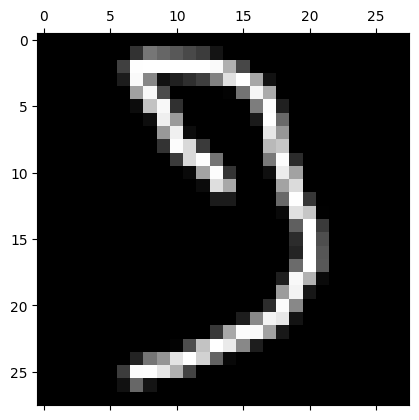

In [ ]:
predict()

Getting the confusion matrix

In [ ]:
class MyDataset():
 
  def __init__(self,X,y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.X[idx], self.y[idx]

In [ ]:
def conf_matrix(data:np.ndarray, labels:np.ndarray):
  dataset = MyDataset(data, labels)

  with torch.no_grad():
      output = ANN(dataset.X)
  _, pred = torch.max(output.data, 1) 

  cm = confusion_matrix(dataset.y, pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=str_categories)
  disp.plot()

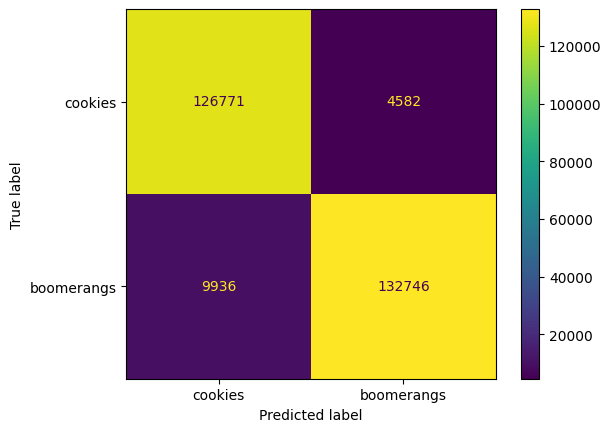

In [ ]:
conf_matrix(X, y)

Here, the accuracy for only two classes is very high, also, the number of wrong classified cookies were 4.500 and the number of wrong boomerangs is almost 10.000

# Convolutional model 

## Data Preparation

Load data and store the resulting `np.ndarray`s in a list

In [ ]:
clocks = np.load("clock.npy")
boomerangs = np.load("boomerang.npy")
airplanes = np.load('airplane.npy')
snails = np.load('snail.npy')
parachutes = np.load('parachute.npy')
trees = np.load('tree.npy')
fish = np.load('fish.npy')
diamonds = np.load('diamond.npy')
helicopters = np.load('helicopter.npy')
t_shirts = np.load("t-shirt.npy")

categories = [clocks, boomerangs, airplanes, snails, parachutes, trees, fish, diamonds, helicopters, t_shirts]
str_categories = ["cloks", "boomerangs", "airplanes", 'snails', 'parachutes', 'trees', "fishes", "diamonds", "helicopters", "t-shirts"]
categories_len = [x.shape[0] for x in categories]

num_labels = len(categories)

Combining all categories in a single dataset. Also creating the labels for the data.

Here, we delete the previous classes in order to clear and reduce the RAM utilization

In [ ]:
X = np.vstack(categories)
y = np.zeros((1, 1))

for i, l in enumerate(categories_len):
  y = np.vstack((y, i*np.ones((l, 1))))

for i in range(len(categories)):
  del[categories[0]]
del categories

y = y[1:, :]

Function to visualize an image given an index in the dataset

In [ ]:
def show_image(data:np.ndarray, index:int) -> None:
  img = data[index, :]
  img = img.reshape(28, 28)
  plt.matshow(img, cmap="gray")

Split the dataset in Training, Validation and Testing sets.

As before, we delete X and Y matrices because we don't use it in the rest of the model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=.9, random_state=41)               # 90% of data will be for training

x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42)     # 10% * 50% = de 5% of data
                                                        # will be used for validation
                                                        # the remaining 5% will be for testing
del(X)
del(y)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_val = x_val.reshape(x_val.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

## Pytorch model 

This time we will be using a convolutional network model from: https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

This particular model will have some changes since the problem to be solved is different

In [ ]:
# Create CNN Model
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3,3), stride=1, padding=1)   # 1 input channel since the image is in black and white format.
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(3136, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, num_labels)
 
    def forward(self, x):
        # input 1x28x28, output 16x28x28
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 16x28x28, output 16x28x28
        x = self.act2(self.conv2(x))
        # input 16x28x28, output 16x14x14
        x = self.pool2(x)
        # input 16x14x14, output 3136
        x = self.flat(x)
        # input 3136, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

Function to create a model, loss function and optimizer

In [ ]:
def createModel(alpha):
  ANN = CIFAR10Model()
  # Loss Function
  lossfun = nn.CrossEntropyLoss()
  # Optimizer
  optimizer = torch.optim.SGD(ANN.parameters(),lr=alpha)
  return ANN,lossfun,optimizer

Function to create and train a model

In [ ]:
def create_and_train(alpha=0.01, epochs=500, verbose=True, save_best=True):

  valid_loss_min = np.inf  #Vamos a encontrar el menor valor de error de validación. Por eso la inicializmaos como 'infinito'.

  # Inicializamos dos listas de accuracies vacías y una lista de pérdidas.
  trainAcc = []
  testAcc  = []
  losses   = []

  # Creamos una instancia de una red neuronal, una función de error y un criterio para minimizar.
  CNN, lossfun, optimizer = createModel(alpha)
  CNN.to(device)

  # Inicializamos una clase para calcular el f1 score
  f1 = F1Score(task="multiclass", num_classes=num_labels).to(device)

  # Iteramos "epochs" veces
  for epoch in range(epochs):


    # ======================================================================== #
    #                                ENTRENAMIENTO                             #
    # ======================================================================== #


    # Activamos el modo entrenamiento.
    CNN.train()

    # Iteramos sobre cada bache de datos en el dataset, inicializamos listas para guardar las pérdidas y precisiones para cada bache.
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # Pasamos los tensores a la GPU
      X = X.to(device)
      y = y.to(device)

      # Hacemos forward propagation y calculamos el error o pérdida.
      yHat = CNN(X)
      loss = lossfun(yHat,y.squeeze())

      # Hacemos backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculamos la precisión de entrenamiento para este bache solamente.
      _, predicted = torch.max(yHat.data, 1)                                                 # Si output > 0.5, la clase es positiva (1). En otro caso, la clase es negativa (0)
      batchAcc.append(100*(predicted == y.squeeze()).sum().detach().item()/y.shape[0])
      batchLoss.append(loss.detach().item())
      # torch.cuda.empty_cache()

    # Terminamos de iterar sobre los baches...

    # Ahora que iteramos sobre todos los baches, obtenemos su precisión y error medio.
    train_acc = np.mean(batchAcc)
    train_loss = np.mean(batchLoss)

    # Guardamos esta información.
    trainAcc.append(train_acc)
    losses.append(train_loss)


    # ======================================================================== #
    #                                 VALIDACIÓN                               #
    # ======================================================================== #

    # Activamos el modo de evaluación de la red
    CNN.eval()

    # Vamos a evaluar el modelo entrenado, calculando predicciones con el conjunto de validación.
    data, target = next(iter(cv_loader))

    # Pasamos los tensores a la GPU
    data = data.to(device)
    target = target.to(device)

    # Activamos el modo de testeo.
    with torch.no_grad():
      output = CNN(data)
    
    # Calculamos la precisión para este bache.
    _, predicted = torch.max(output.data, 1)
    test_acc = 100*(predicted == target.squeeze()).sum().detach().item()/target.shape[0]
    testAcc.append(test_acc)

    # Calculamos el puntaje F1 (Nos dice qué tan bien se desempeña el modelo teniendo en relación a las
    # predicciones de falsos positivos y falsos negativos en las qwe incurre).
    _, predicted = torch.max(output.data, 1)
    predicted = predicted.to(device)
    f1score = f1(predicted, target.squeeze())

    # Calculamos el error de validación
    valid_loss = lossfun(output, target.squeeze())
    valid_loss += loss.item()*data.size(0)
    valid_loss = valid_loss/len(cv_loader.dataset)

    # ============================================ #
    #                GUARDAR EL MODELO             #
    # ============================================ #

    #Guardamos el modelo con el menor error de validación.
    if valid_loss <= valid_loss_min:
        if verbose:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        if save_best:
          torch.save(CNN.state_dict(), 'Model.pt')
        valid_loss_min = valid_loss

    # Prints para saber el estado de entrenamiento del modelo
    if verbose:
      print(f"Training[{epoch:03d}/{epochs:03d}] | Loss: {train_loss:.5f}\tTrain Accuracy:{train_acc:.5f}%\tValidation Loss:{valid_loss:.5f}\t    Validation Accuracy:{test_acc:.5f}%\tF1 Score:{f1score:.5f}\n")

    torch.cuda.empty_cache()

  # torch.cuda.empty_cache()
  # Retornamos el modelo, las listas donde guardamos las pérdidas y precisiones, la función de pérdida y el criterio.
  return CNN, trainAcc, testAcc, losses, valid_loss_min
    

    

Create the DataLoaders

In [ ]:
train_dataDataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.LongTensor))
cv_dataDataset  = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val).type(torch.LongTensor))
test_dataDataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test).type(torch.LongTensor))

cv_loader = DataLoader(cv_dataDataset,batch_size=cv_dataDataset.tensors[0].shape[0])
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

Training the model

In [ ]:
# train_model(model, optimizer, criterion, train_data, val_data, num_epochs=100)
batch_size = 2048
epochs = 20
alpha = 0.04

train_loader = DataLoader(train_dataDataset, batch_size=batch_size, shuffle=True, drop_last=True)
CNN, trainAcc, testAcc, losses, valid_loss_min = create_and_train(alpha=alpha, epochs=epochs, verbose=True)

Validation loss decreased (inf --> 0.693222).  Saving model ...
Training[000/020] | Loss: 1.38924	Train Accuracy:53.03992%	Validation Loss:0.69322	    Validation Accuracy:81.48942%	F1 Score:0.81489

Validation loss decreased (0.693222 --> 0.589111).  Saving model ...
Training[001/020] | Loss: 0.57972	Train Accuracy:81.99816%	Validation Loss:0.58911	    Validation Accuracy:81.10154%	F1 Score:0.81102

Validation loss decreased (0.589111 --> 0.415501).  Saving model ...
Training[002/020] | Loss: 0.47342	Train Accuracy:85.49691%	Validation Loss:0.41550	    Validation Accuracy:89.91499%	F1 Score:0.89915

Validation loss decreased (0.415501 --> 0.369077).  Saving model ...
Training[003/020] | Loss: 0.40570	Train Accuracy:87.69142%	Validation Loss:0.36908	    Validation Accuracy:90.60326%	F1 Score:0.90603

Validation loss decreased (0.369077 --> 0.363793).  Saving model ...
Training[004/020] | Loss: 0.36380	Train Accuracy:89.00662%	Validation Loss:0.36379	    Validation Accuracy:91.95357%	F1 

In [ ]:
mem_params = sum([param.nelement()*param.element_size() for param in CNN.parameters()])
mem_bufs = sum([buf.nelement()*buf.element_size() for buf in CNN.buffers()])
mem = mem_params + mem_bufs # in bytes
mem

6455016

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                   helicopters: 119.6 MiB
                     airplanes: 113.4 MiB
                         trees: 108.2 MiB
                    boomerangs: 106.7 MiB
                          fish: 100.3 MiB
                        snails: 100.0 MiB
                      diamonds: 98.4 MiB
                    parachutes: 95.2 MiB
                      t_shirts: 93.6 MiB
                        clocks: 90.1 MiB


Function to make predictions for a certain (or random image)

In [ ]:
def predict(data, labels, random=True, idx=0):
  if random:
    idx = randint(0, data.shape[0])

  x = torch.Tensor(data[idx, :])
  x = x.to(device)

  CNN.eval()
  with torch.no_grad():
    output = CNN(x)
    S = nn.Softmax(dim=0)
    print(S(output.data))
  _, pred = torch.max(output.data, 0) 
  label = labels[idx]

  show_image(data, idx)
  print("prediction: ", pred.item())
  print("label: ", int(label.item()))

  CNN.train()

In [ ]:
#predict(np_image1, np.array([1]), random=False)

In [ ]:
#predict(np_image2, np.array([1]), random=False)

Auxiliary Class

In [ ]:
class MyDataset():
 
  def __init__(self,X,y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.X[idx], self.y[idx]

Confusion Matrix

In [ ]:
def conf_matrix(data:np.ndarray, labels:np.ndarray):
  dataset = MyDataset(data, labels)

  with torch.no_grad():
      data = dataset.X.to(device)
      output = CNN(data)
  _, pred = torch.max(output.data, 1) 

  pred = pred.cpu()
  cm = confusion_matrix(dataset.y, pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=str_categories)
  disp.plot()

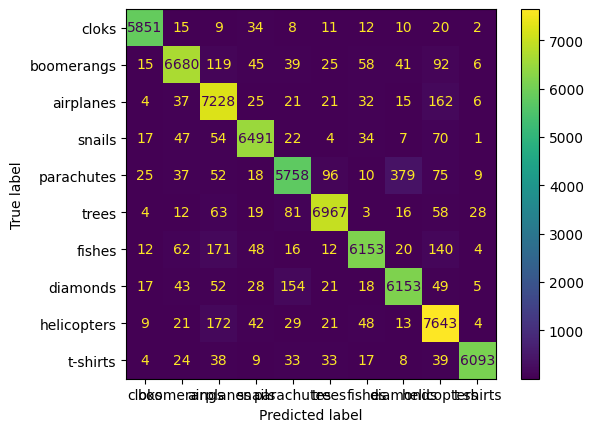

In [ ]:
conf_matrix(x_test, y_test)

Here, we achieved an accuracy similar to the one of the preeliminary model. However, it is a better result since we are working with 10 clases instead of two.

Also, looking at the confusion matrix, the number of errors made by the model is very low taking into account the number of elements in each class.

When working with images and classifying multiple clases, it is better to work with convolutional network.

Finally, when we work with big amount of data, we must be careful with memory utilization so we need to be deleting the information that we won't use anymore.